# Predicting covid19 infection using machine learning

In this notebook we are going to look into different metrics and how they affect whether you are going to contract covid19 or not.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

# Table of contents
1. [Problem Definition](#problemdefinition)
2. [Data](#data)
3. [Evaluation](#evaluation)
4. [Features](#features)
5. [Modelling](#modelling)
6. [Experimentation](#experimentation)

## 1. Problem definition <a name="problemdefinition"></a>

In a statement,
> Can we predict whether someone has covid or not based on different metrics?

## 2. Data <a name="data"></a>

The data came from https://www.kaggle.com/zhiruo19/covid19-symptoms-classification.

Not sure if the data is accurate or the actual source of it.

## 3. Evaluation <a name="evaluation"></a>

> If we can reach 90% accuracy at predicting whether or not a patient has covid19 or not, this project would be classified as successful. 

## 4. Features <a name="features"></a>

Data dictionary: 

fever
bodypain	
age	
runnynose	
diffbreath	
infected


### Questions:

1. Difficulty breathing:
  -  -1: No (???)
  -  0: I don't know (???)
  -  1: Yes (???)

In [1]:
# Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

# Data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import plot_importance

In [2]:
df = pd.read_csv('covid19data.csv')
df.head()

,fever,bodypain,age,runnynose,diffbreath,infected
0,99.329862,0,26,1,-1,0
1,98.115263,1,61,1,0,1
2,99.918088,1,13,0,-1,0
3,101.344456,1,55,1,0,1
4,100.056678,1,37,0,1,0


In [3]:
len(df)

1999

In [4]:
df.isna().sum()

fever         0
bodypain      0
age           0
runnynose     0
diffbreath    0
infected      0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.fever.describe().T

count    1999.000000
mean      100.512027
std         1.438389
min        98.005787
25%        99.255045
50%       100.521666
75%       101.728421
max       102.995724
Name: fever, dtype: float64

In [7]:
df.bodypain.value_counts()

0    1023
1     976
Name: bodypain, dtype: int64

In [8]:
df.age.describe()

count    1999.000000
mean       47.331666
std        20.467449
min        12.000000
25%        30.000000
50%        48.000000
75%        65.000000
max        82.000000
Name: age, dtype: float64

In [9]:
df.runnynose.value_counts()

0    1001
1     998
Name: runnynose, dtype: int64

In [10]:
df.diffbreath.value_counts()

-1    690
 0    667
 1    642
Name: diffbreath, dtype: int64

In [11]:
df.infected.value_counts()

1    1007
0     992
Name: infected, dtype: int64

In [12]:
992 / (1007 + 992)

0.496248124062031

Create a heatmap in order to understand how each metric correlates to each other

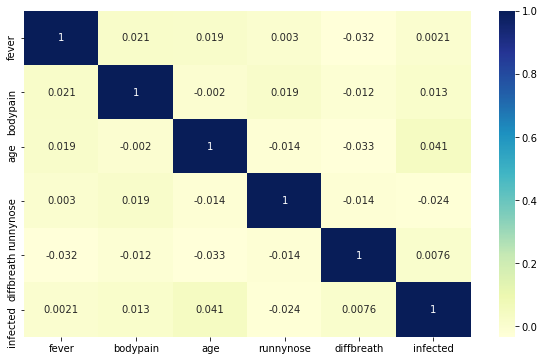

In [13]:
# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(df.corr(),
                annot=True,
                cmap='YlGnBu')

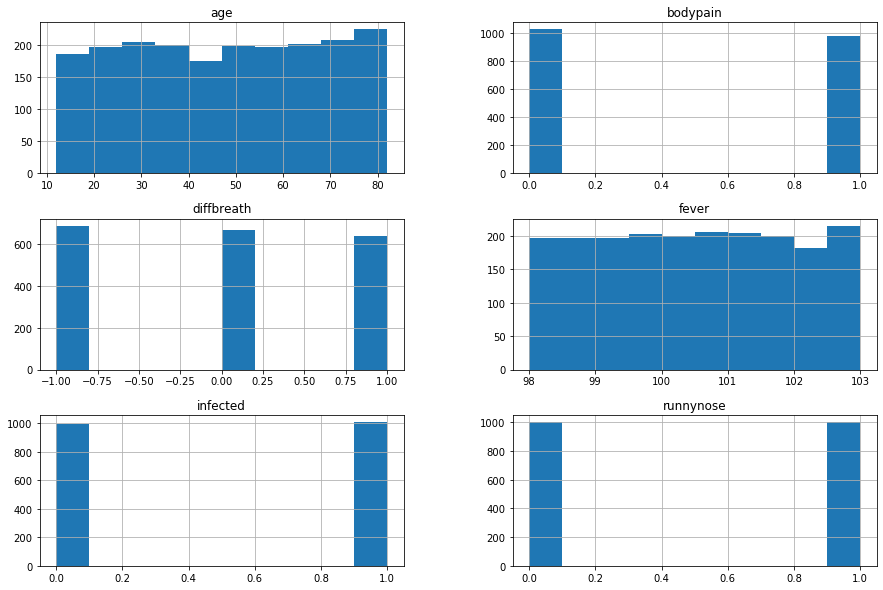

In [14]:
df.hist(figsize=(15, 10));

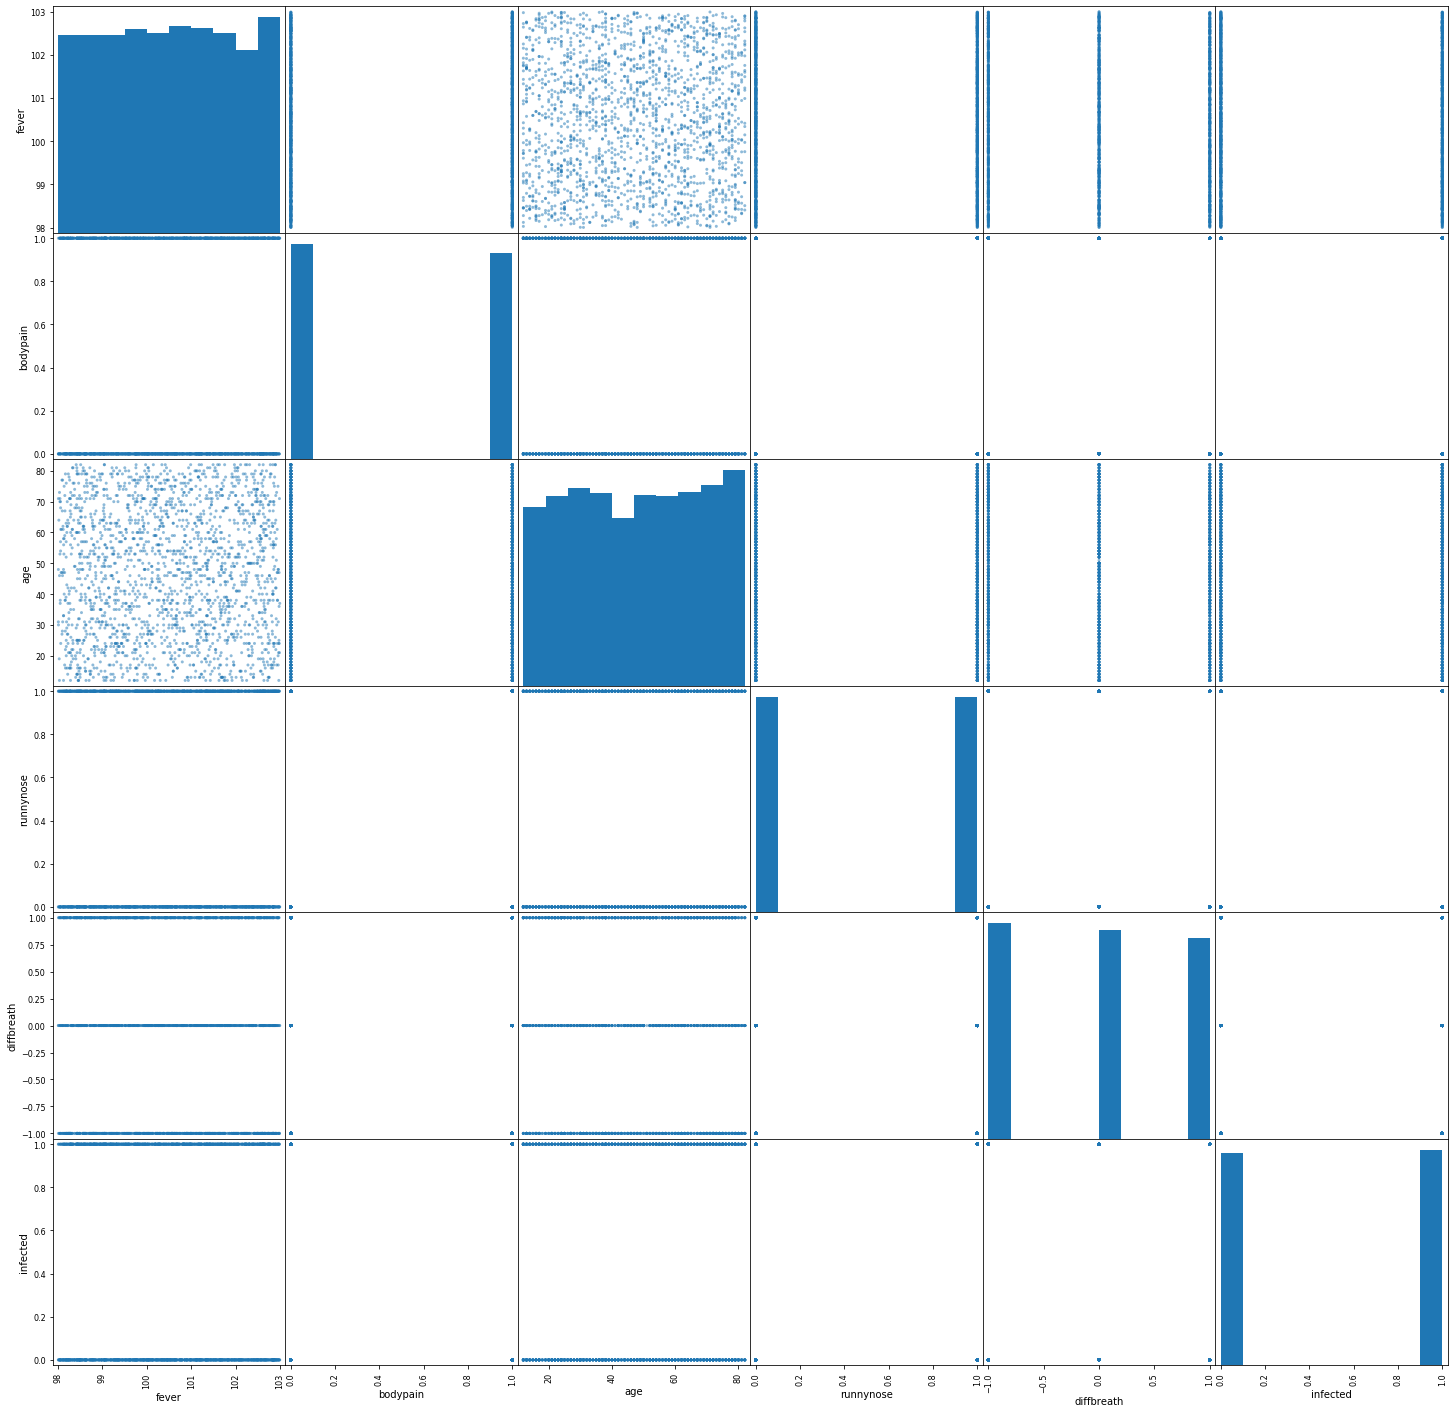

In [15]:
# Import a scatter_matrix
from pandas.plotting import scatter_matrix
scatter_matrix_plot = scatter_matrix(df, figsize=(25, 25))

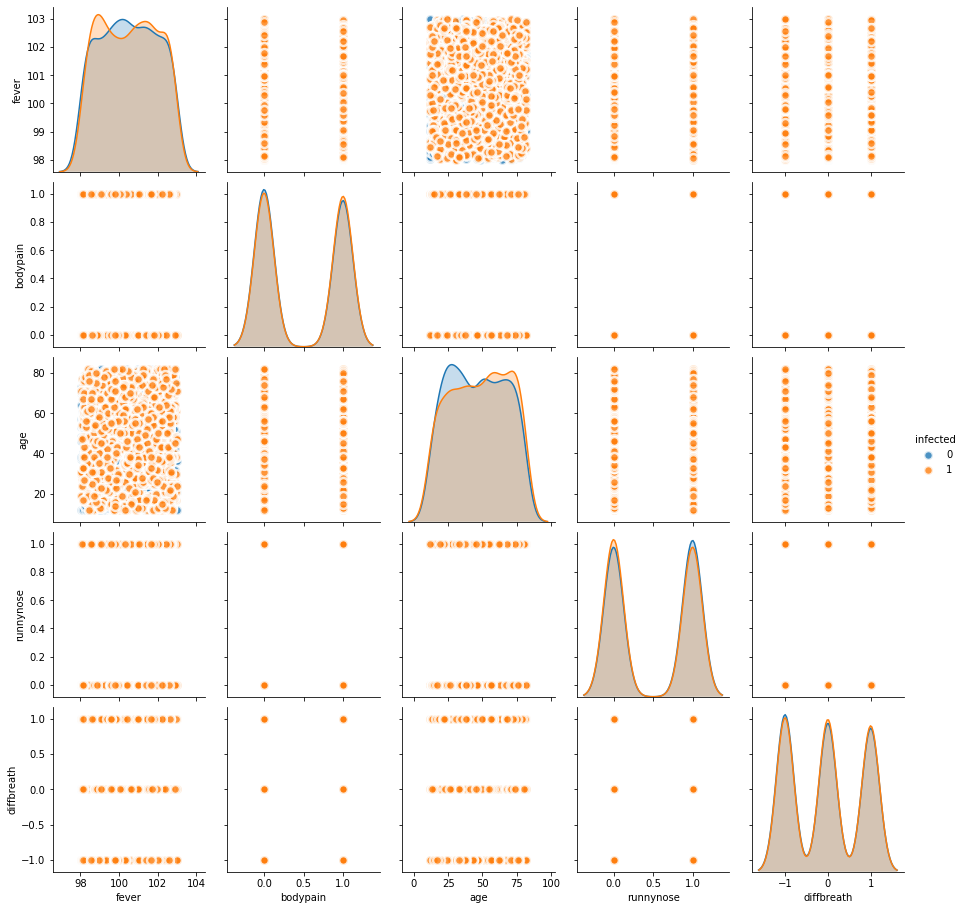

In [16]:
df_pairplot = sns.pairplot(df, hue='infected', plot_kws=dict(s=80, edgecolor='white', linewidth=2.5, alpha=0.8))

In [17]:
df.head()

,fever,bodypain,age,runnynose,diffbreath,infected
0,99.329862,0,26,1,-1,0
1,98.115263,1,61,1,0,1
2,99.918088,1,13,0,-1,0
3,101.344456,1,55,1,0,1
4,100.056678,1,37,0,1,0


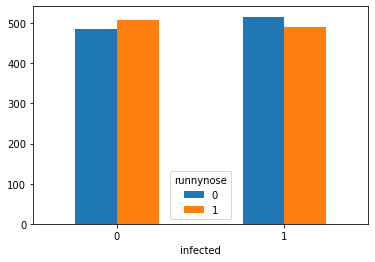

In [18]:
pd.crosstab(df.runnynose, df.infected).T.plot.bar()
plt.xticks(rotation=0);

# 5. Modelling <a name='modelling'></a>

In [19]:
# Splitting data with David
#X = np.array(df['age']).reshape(-1, 1)
#y = df['infected']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# Split the data
X = df.drop('infected', axis=1)
y = df['infected']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
model_dict = {'RandomForestClassifier': RandomForestClassifier(),
             'XGB': xgb.XGBClassifier(),
             'LogisticRegression': LogisticRegression(),
             'KNeighborsClassifier': KNeighborsClassifier(),
             'SVC': SVC()}
model_results = {}

def test_model(X_train, X_test, y_train, y_test):
    np.random.seed(42)
    for name, model in model_dict.items():
        model.fit(X_train, y_train)
        model_results[name] = model.score(X_test, y_test)
    return model_results

In [22]:
test_model(X_train, X_test, y_train, y_test)

{'RandomForestClassifier': 0.5625,
 'XGB': 0.52,
 'LogisticRegression': 0.5375,
 'KNeighborsClassifier': 0.5275,
 'SVC': 0.5125}

In [23]:
grid = {"learning_rate": [0.15, 0.30],
     "max_depth": [6, 15],
     "min_child_weight": [3, 7],
     "gamma": [0.1, 0.2],
     "colsample_bytree": [ 0.3,0.7 ],}

In [24]:
gs_xgb = GridSearchCV(xgb.XGBClassifier(n_jobs=-1),
                     param_grid=grid,
                     cv=5,
                     verbose=True)

gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   16.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
           

In [25]:
gs_xgb.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.2,
 'learning_rate': 0.15,
 'max_depth': 15,
 'min_child_weight': 7}

In [26]:
np.random.seed(42)

# Instantiate XGB
clf = xgb.XGBClassifier(gamma=0.2, colsample_bytree=0.3, learning_reate=0.15,
                       max_depth=15,
                       min_child_weight=7)

# Fit the data
clf.fit(X_train, y_train)

# Score the data
clf.score(X_test, y_test)

[11:45:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.505

In [27]:
# Make predictions with tuned model
y_preds = clf.predict(X_test)

In [28]:
y_preds;

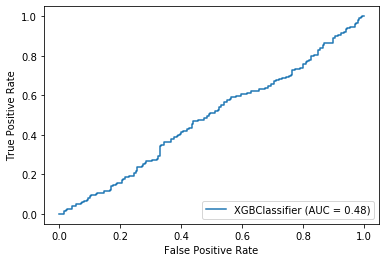

In [29]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(clf, X_test, y_test);

In [30]:
# Confusion matrix
confusion_matrix(y_test, y_preds)

array([[100, 100],
       [ 98, 102]], dtype=int64)

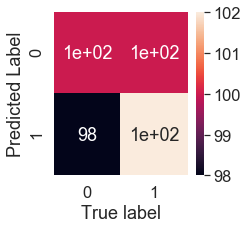

In [31]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot=True,
                    cbar=True)
    plt.xlabel("True label")
    plt.ylabel("Predicted Label")

plot_conf_mat(y_test, y_preds)

Let's get classification report 

In [32]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       200
           1       0.50      0.51      0.51       200

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.50       400



### Calculate evaluation metrics using cross-validation

We're going to calculate accuracy, precision, recall, f1-score using `cross_val_score()`

In [33]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                        X,
                        y,
                        cv=5,
                        scoring='accuracy')

cv_acc = np.mean(cv_acc)
cv_acc

[11:45:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used

0.5267631578947368

In [34]:
# Cross-validated precision
cv_precision = cross_val_score(clf,
                              X,
                              y,
                              cv=5,
                              scoring='precision')
cv_precision = np.mean(cv_precision)
cv_precision

[11:45:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used

0.5291854325729328

In [35]:
# Coss-validated recall
cv_recall = cross_val_score(clf,
                           X,
                           y,
                           cv=5,
                           scoring='recall')
cv_recall = np.mean(cv_recall)
cv_recall

[11:45:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used

0.5491502881631447

In [36]:
# Cross-validated f1 score
cv_f1 = cross_val_score(clf,
                       X,
                       y,
                       cv=5,
                       scoring='f1')
cv_f1 = np.mean(cv_f1)
cv_f1

[11:45:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used

0.5388322114665081

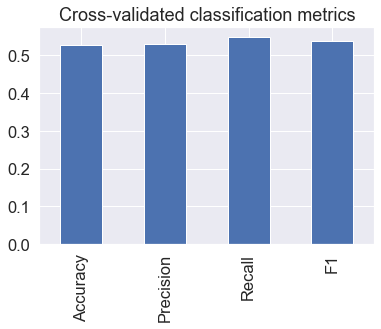

In [37]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({'Accuracy': cv_acc,
                          'Precision': cv_precision,
                          'Recall': cv_recall,
                          'F1': cv_f1},
                         index=[0])

cv_metrics.T.plot.bar(title='Cross-validated classification metrics',
                     legend=False);

### Feature Importance

Which features contributed most to the outcomes of the model and how did they contribute?

In [38]:
df.head()

,fever,bodypain,age,runnynose,diffbreath,infected
0,99.329862,0,26,1,-1,0
1,98.115263,1,61,1,0,1
2,99.918088,1,13,0,-1,0
3,101.344456,1,55,1,0,1
4,100.056678,1,37,0,1,0


[11:45:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_reate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




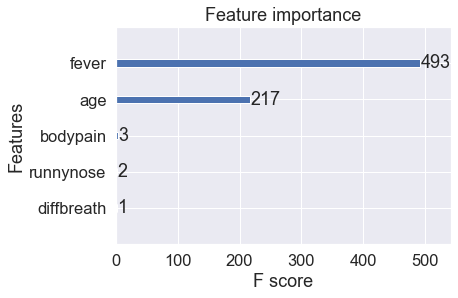

In [42]:
np.random.seed(42)

# Instantiate XGB
clf = xgb.XGBClassifier(gamma=0.2, colsample_bytree=0.3, learning_reate=0.15,
                       max_depth=15,
                       min_child_weight=7)

# Fit the data
clf.fit(X_train, y_train)

# Plot feature importance
plot_importance(clf);

## 6. Experimentation <a name="experimentation"></a>

We haven't hit our goal of > 90% accuracy.

* Could we collect more data?
* Maybe we can try a better model?
* Could we improve the current models even more?